In [39]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import datasets
from IPython.display import display, HTML

In [40]:
# Clarifying orientation of confusion matrix
# Here we see that 
# - rows i represent true values
# - columns j represent predictions


y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

confusion_matrix(y_true, y_pred)

array([[2, 0],
       [1, 3]], dtype=int64)

In [41]:
def confusion_table(confusion_mtx):
    """Renders a nice confusion table with labels"""
    confusion_df = pd.DataFrame({'y_pred=0': np.append(confusion_mtx[:, 0], confusion_mtx.sum(axis=0)[0]),
                                 'y_pred=1': np.append(confusion_mtx[:, 1], confusion_mtx.sum(axis=0)[1]),
                                 'Total': np.append(confusion_mtx.sum(axis=1), ''),
                                 '': ['y=0', 'y=1', 'Total']}).set_index('')
    return confusion_df


def positive_observations(y):
    # What percentage of observations are positive?
    proportion_1 = ((y == 1).sum() / len(y))
    pct_1        = np.around(proportion_1*100, decimals=3)
    display(HTML('<p><h4>{}%</h4>of observations are positive</p>'.format(pct_1)))


# Classifier stats
# -------------------------------------------------

def prior_error_rate(confusion_matrix):
    """The prior probability that a result is positive"""
    return 1 - (np.sum(confusion_mtx[1, :]) / np.sum(confusion_mtx))

def total_error_rate(confusion_matrix):
    """Derive total error rate from confusion matrix"""
    return 1 - np.trace(confusion_mtx) / np.sum(confusion_mtx)

def true_positive_rate(confusion_mtx):
    """or sensitivity: the proportion of actual POSITIVES that are correctly identified as such"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[1, :])

def false_negative_rate(confusion_mtx):
    """the proportion of actual POSITIVES that are incorrectly identified as negative"""
    return confusion_mtx[1, 0] / np.sum(confusion_mtx[1, :])

def false_positive_rate(confusion_mtx):
    """the proportion of actual NEGATIVES that are incorrectly identified as positives"""
    return confusion_mtx[0, 1] / np.sum(confusion_mtx[0, :])

def true_negative_rate(confusion_mtx):
    """or specificity: the proportion of actual NEGATIVES that are correctly identified as such"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[0, :])

def positive_predictive_value(confusion_mtx):
    """or precision: the proportion of predicted positives that are correctly predicted"""
    return confusion_mtx[1, 1] / np.sum(confusion_mtx[:, 1])

def negative_predictive_value(confusion_mtx):
    """the proportion of predicted negatives that are correctly predicted"""
    return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])

def classifier_stats(confusion_mtx):
    return pd.Series({'prior_error_rate': prior_error_rate(confusion_mtx),
                      'total_error_rate': total_error_rate(confusion_mtx),
                      'true_positive_rate (sensitivity)': true_positive_rate(confusion_mtx),
                      'false_negative_rate': false_negative_rate(confusion_mtx),
                      'false_positive_rate': false_positive_rate(confusion_mtx),
                      'true_negative_rate (specificity)': true_negative_rate(confusion_mtx),
                      'positive_predictive_value (precision)': positive_predictive_value(confusion_mtx),
                      'negative_predictive_value': negative_predictive_value(confusion_mtx)})


In [42]:
from sklearn.neighbors import KNeighborsClassifier


In [43]:
auto_df = pd.read_csv('auto.csv')

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
auto_df = auto_df.reset_index()

# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'],
             'qual': ['name']}

quants = auto_df[datatypes['quant']].astype(np.float_)
auto_df = pd.concat([quants, auto_df[datatypes['qual']]], axis=1) 

# Add mpg01 feature
mpg01   = (auto_df['mpg'] > auto_df['mpg'].median()/2).astype(np.float64)
auto_df = pd.concat([auto_df, mpg01.rename('mpg01')], axis=1).drop('mpg', axis=1)
auto_df.head()

display(auto_df.head())

,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,1.0
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,1.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,1.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,1.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,1.0


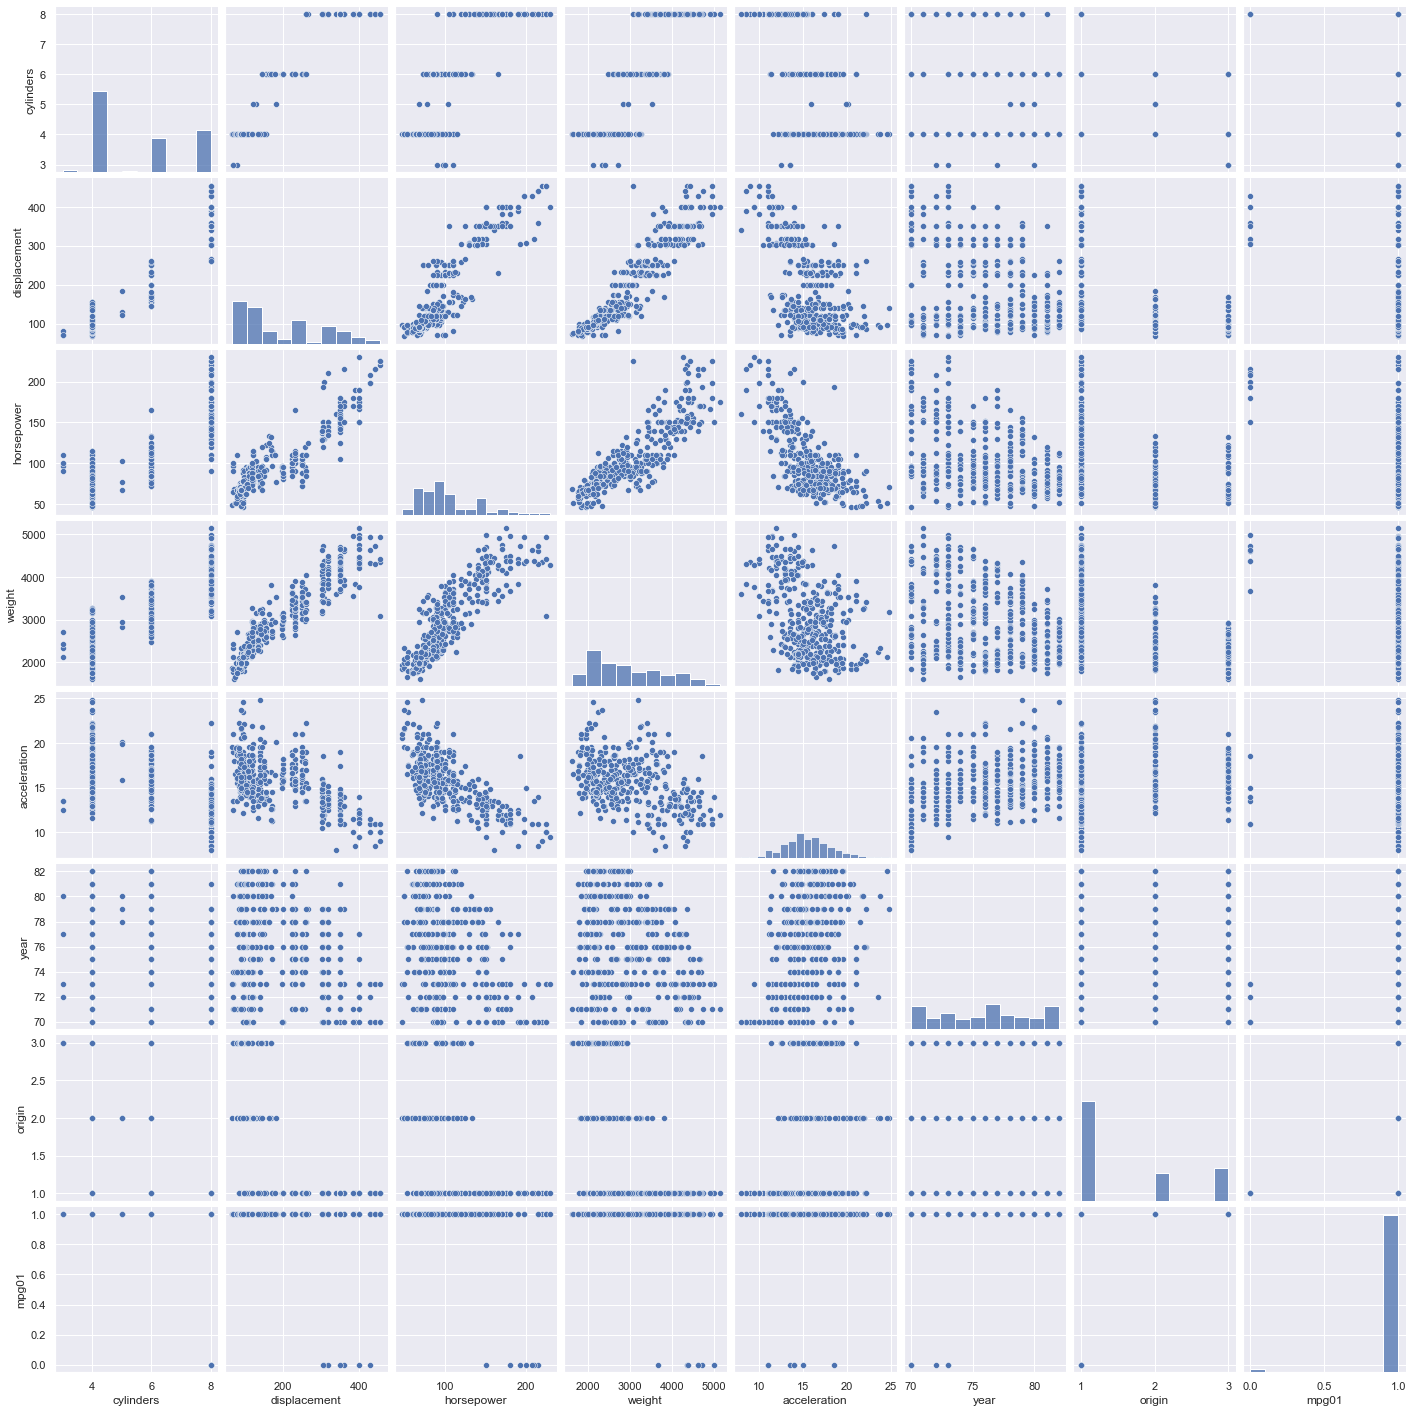

In [44]:
sns.pairplot(auto_df);

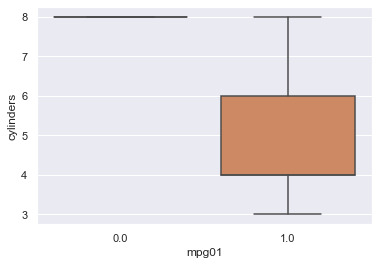

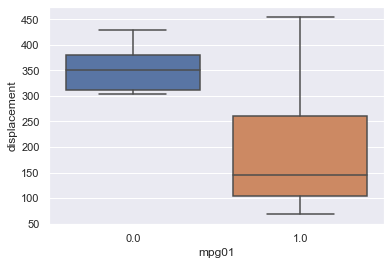

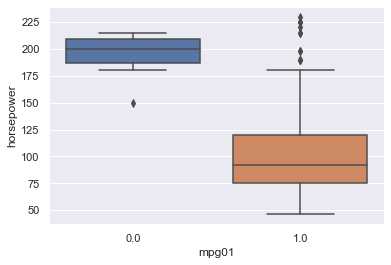

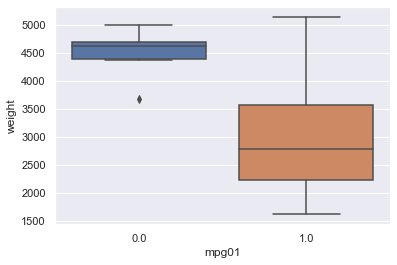

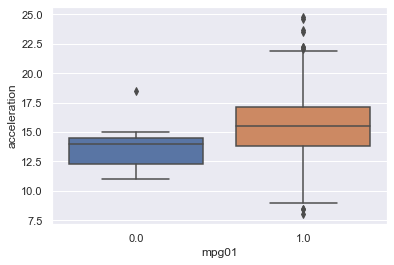

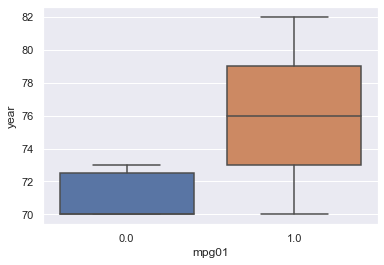

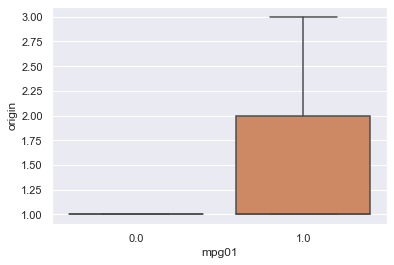

In [45]:
for c in auto_df.columns.drop(['mpg01', 'name']):
    sns.boxplot(x=auto_df['mpg01'], y=auto_df[c])
    plt.show();

Weight, displacement and cyclinders look like the most predictive features.

In [46]:
# Create index for training set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

# Training set (70%)
display(HTML('<h3>Training set</h3>'))
display(auto_df[train].head())

# Test set (30%)
display(HTML('<h3>Test set</h3>'))
display(auto_df[~train].head())


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,1.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,1.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,1.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,1.0
5,8.0,429.0,198.0,4341.0,10.0,70.0,1.0,ford galaxie 500,1.0


,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,1.0
13,8.0,455.0,225.0,3086.0,10.0,70.0,1.0,buick estate wagon (sw),1.0
20,4.0,110.0,87.0,2672.0,17.5,70.0,2.0,peugeot 504,1.0
21,4.0,107.0,90.0,2430.0,14.5,70.0,2.0,audi 100 ls,1.0
24,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin,1.0


In [47]:


# Create index for training set
np.random.seed(1)
train_idx = np.random.rand(len(auto_df)) < 0.7
auto_df_train = auto_df[train_idx]
auto_df_test  = auto_df[~train_idx]

In [48]:
# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])

# MODELS
# Logistic Regression
#model_logit = sm.Logit(y_train, X_train).fit() <--- this technique didn't converge
logit       = LogisticRegression()
model_logit = logit.fit(X_train, y_train)
# LDA
lda         = LinearDiscriminantAnalysis()
model_lda   = lda.fit(X_train, y_train)
# QDA
qda         = QuadraticDiscriminantAnalysis()
model_qda   = qda.fit(X_train, y_train)


models = {'logit': model_logit, 
          'lda': model_lda, 
          'qda': model_qda}
scaled = []


# PREDICT
for k in models:
    # Predict
    if k in scaled:
        y_pred = models[k].predict(preprocessing.scale(X_test))
    else:
        y_pred = models[k].predict(X_test)
    # Confusion table
    display(HTML('<h3>{}</h3>'.format(k)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    # Classifier stats
    display(classifier_stats(confusion_mtx))



C:\Users\erikl\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\erikl\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


prior_error_rate                         0.016667
total_error_rate                         0.016667
true_positive_rate (sensitivity)         1.000000
false_negative_rate                      0.000000
false_positive_rate                      1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.983333
negative_predictive_value                     NaN
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


prior_error_rate                         0.016667
total_error_rate                         0.016667
true_positive_rate (sensitivity)         1.000000
false_negative_rate                      0.000000
false_positive_rate                      1.000000
true_negative_rate (specificity)         0.000000
positive_predictive_value (precision)    0.983333
negative_predictive_value                     NaN
dtype: float64

,y_pred=0,y_pred=1,Total
,,,
y=0,2,0,2
y=1,14,104,118
Total,16,104,


prior_error_rate                         0.016667
total_error_rate                         0.116667
true_positive_rate (sensitivity)         0.881356
false_negative_rate                      0.118644
false_positive_rate                      0.000000
true_negative_rate (specificity)         1.000000
positive_predictive_value (precision)    1.000000
negative_predictive_value                0.125000
dtype: float64

In [49]:


# Create index for holdout set
np.random.seed(1)
train = np.random.rand(len(auto_df)) < 0.7

predictors  = ['weight', 'cylinders', 'year', 'acceleration']
#predictors  = auto_df.columns.drop(['mpg01', 'name'])
X_train = np.array(auto_df[train][predictors])
y_train = np.array(auto_df[train]['mpg01'])
X_test  = np.array(auto_df[~train][predictors])
y_test  = np.array(auto_df[~train]['mpg01'])



# PREDICT
for K in range(1, 21):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(preprocessing.scale(X_train), y_train)
    # Predict
    y_pred = model.predict(preprocessing.scale(X_test))
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y_test, y_pred)
    display(confusion_table(confusion_mtx))
    
    # Classifier stats
    print('total_error_rate: \n' + str(classifier_stats(confusion_mtx)['total_error_rate']))

,y_pred=0,y_pred=1,Total
,,,
y=0,1,1,2
y=1,3,115,118
Total,4,116,


total_error_rate: 
0.033333333333333326


,y_pred=0,y_pred=1,Total
,,,
y=0,1,1,2
y=1,5,113,118
Total,6,114,


total_error_rate: 
0.050000000000000044


,y_pred=0,y_pred=1,Total
,,,
y=0,1,1,2
y=1,0,118,118
Total,1,119,


total_error_rate: 
0.008333333333333304


,y_pred=0,y_pred=1,Total
,,,
y=0,1,1,2
y=1,0,118,118
Total,1,119,


total_error_rate: 
0.008333333333333304


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


total_error_rate: 
0.01666666666666672


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


,y_pred=0,y_pred=1,Total
,,,
y=0,0,2,2
y=1,0,118,118
Total,0,120,


total_error_rate: 
0.01666666666666672


C:\Users\erikl\AppData\Local\Temp/ipykernel_21684/1084497157.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
  return confusion_mtx[0, 0] / np.sum(confusion_mtx[:, 0])


**Comment**

- KNN beats QDA with a total error rate of 7.5% for K = {1, 3, 5, 7, 8} and a slightly lower false positive rate
- the confusion matrix is identical for all top performing K values
- the same predictors appear to work best for KNN as for parametric techniques

## 12. This problem involves writing functions.


### (a) Write a function, Power(), that prints out the result of raising 2 to the 3rd power. In other words, your function should compute $2^3$ and print out the results.
Hint: Recall that x^a raises x to the power a. Use the print() function to output the result.

### (b) Create a new function, Power2(), that allows you to pass any two numbers, x and a, and prints out the value of x^a

In [50]:
def Power(x, a):
    return np.power(x, a)

### (c) Using the Power2() function that you just wrote, compute $10^3$, $8^{17}$, and $131^3$.

### (d) Now create a new function, Power3(), that actually returns the result x^a as an R object, rather than simply printing it to the screen.


In [51]:
display(HTML('<p>10^3 = {}</p>'.format(Power(10, 3))))
display(HTML('<p>10^3 = {}</p>'.format(Power(8, 17))))
display(HTML('<p>10^3 = {}</p>'.format(Power(131, 3))))

### (e) Now using the Power3() function, create a plot of $f(x) = x^2$. The x-axis should display a range of integers from 1 to 10, and the y-axis should display x2. Label the axes appropriately, and use an appropriate title for the figure. Consider displaying either the x-axis, the y-axis, or both on the log-scale. You can do this by using log=‘‘x’’, log=‘‘y’’, or log=‘‘xy’’ as arguments to the plot() function.


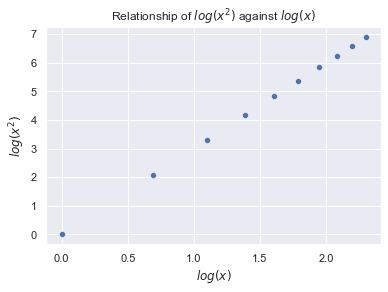

In [52]:
x = np.arange(1, 11)
y = Power(x, 3)

ax = sns.scatterplot(x=np.log(x), y=np.log(y))
plt.xlabel('$log(x)$')
plt.ylabel('$log(x^2)$')
plt.title('Relationship of $log(x^2)$ against $log(x)$')
plt.show();

### (f) Create a function, PlotPower(), that allows you to create a plot of x against x^a for a fixed a and for a range of values of x. For instance, if you call

```
> PlotPower (1:10 ,3)
```

### then a plot should be created with an x-axis taking on values 1,2,...,10, and a y-axis taking on values 13,23,...,103.

In [53]:
def PlotPower(start, stop, power):
    x = np.arange(start, stop+1)
    y = np.power(x, power)
    
    ax = sns.scatterplot(x=x, y=y)
    plt.xlabel('$x$')
    plt.ylabel('$x^{}$'.format(power))
    plt.title('Relationship of $x^{}$ against $x$'.format(power))
    plt.show();
    

def PlotPowerLogs(start, stop, power):
    x = np.arange(start, stop+1)
    y = np.power(x, power)
    
    ax = sns.scatterplot(x=np.log(x), y=np.log(y))
    plt.xlabel('$log(x)$')
    plt.ylabel('$log(x^{})$'.format(power))
    plt.title('Relationship of $log(x^{})$ against $log(x)$'.format(power))
    plt.show();

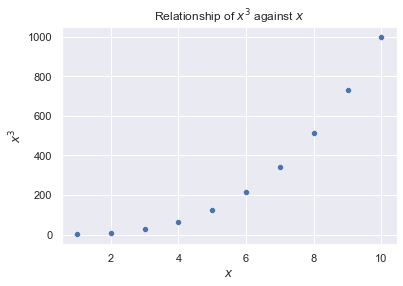

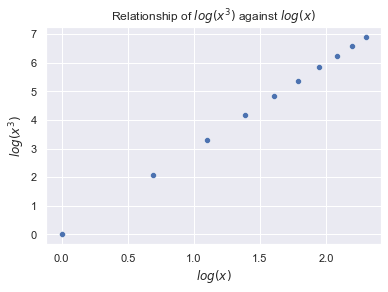

In [54]:
PlotPower(1, 10, 3)
PlotPowerLogs(1, 10, 3)

**CONCLUSIONES**

1. **Modelo KNN (k=4 y k=3): Total Error Rate = 0.0083**
2. **Modelo LDA: Total Error Rate = 0.016**
3. **Modelo QDA: Total Error Rate = 0.116**

En comparación con estos resultados concluimos lo siguiente:

1. **Modelo KNN (k=4 y k=3)**: El modelo KNN con k=4 tiene la tasa de error más baja, con un total error rate de 0.0083, lo que indica una muy buena capacidad de clasificación. Un total error rate tan bajo sugiere que este modelo es eficaz en la tarea de clasificación y es el más preciso de los tres modelos.

2. **Modelo LDA**: El modelo LDA tiene un total error rate de 0.016, lo que es más alto que el KNN pero aún relativamente bajo. Aunque es menos preciso que el KNN en este conjunto de datos, todavía es una opción decente.

3. **Modelo QDA**: El modelo QDA muestra el total error rate más alto, 0.116. Esto significa que tiene un rendimiento significativamente peor en comparación con los otros dos modelos. Un total error rate tan alto sugiere que el modelo QDA no es tan efectivo en la clasificación y que puede haber problemas en su capacidad para distinguir entre clases.

En resumen, considerando para la selección de modelos es la tasa de error total, el modelo KNN con k=4 es el más adecuado para nuestro conjunto de datos, seguido por el modelo LDA. El modelo QDA tiene un rendimiento inferior en términos de tasa de error.

Teniendo en cuenta el punto de corte para la clasificacion binaria. Se podría llegar a pensar que los modelos presentan un problea de sobreajuste en la clasificacion sin embargo para poder estar seguros se debería hacer más pruebas com los datos de entrenamiento vds los de ajuste. 